In [ ]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [19]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from concrete.ml.sklearn import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.linear_model import LinearRegression as skLinear
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time, numpy
import pandas as pd

start_time = time.time()
def feature_selection(x, opt = "", var_percent = 0.8, n_features = 30):
    if opt == "var":
        print("\nUsing variance threshold feature selection...")
        # Remove all features that have low variance in more than (percent)% of the samples.
        #percent = .80
        sel = VarianceThreshold(threshold=(var_percent * (1 - var_percent)))
        print("Shape of X: ", x.shape)
        #print(x.iloc[0])
        x = sel.fit_transform(x)
        print("After feature selection: ", len(x[0]), " features")
        #print(x[0])
        cols_idxs = sel.get_support(indices=True)
    elif opt == "kbest":
        print("\nUsing K best features feature selection...")
        print("Shape of x before selection: ", x.shape)
        selector = SelectKBest(chi2, k=n_features)
        x = selector.fit_transform(x, y)
        
        cols_idxs = selector.get_support(indices=True)
        
        print("Shape of x after selection: ", x.shape)
    elif opt == "pca":
        print("\nUsing PCA feature selection...")
        x_scaled = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_features)
        pca_features = pca.fit_transform(x_scaled)
        print('Shape before PCA: ', x_scaled.shape)
        print('Shape after PCA: ', pca_features.shape)
        x = pca_features
        cols_idxs = pca.get_support(indices=True)
    else:
        print("")
    return x, cols_idxs

#select set option
set = -1

#import the dataset here (GISAID; try downloading individual FASTA files if di talaga kaya idownload yung EPISET)
#if(set == -1):
#    dataset_name = "AFHE DATASET (05-04-2023).csv"
#elif(set == 0):
#    dataset_name = "ADJUSTED DATASET (05-04-2023).csv"
#else:
#    dataset_name = "ADJUSTED DOWNSIZED DATASET (05-04-2023).csv"
#dataset = pd.read_csv(dataset_name)

dataset = pd.read_csv("AFHE DATASET (05-18-2023).csv")

#print(dataset['Lineage'].value_counts())

#remove "EPI_ISL_" from ID
#new_ID_col = []
#for i in range(0, len(dataset['Accession ID'])):
#    new_ID_col.append(str(dataset['Accession ID'].loc[i].replace("EPI_ISL_", "")))
#dataset['Accession ID'] = new_ID_col

feature_cols = [c for c in dataset.columns[2:]]
#print(feature_cols)

x = dataset.loc[:,feature_cols].values #must be floats
y = dataset.loc[:,'Lineage'].values #must be integers

#print(x)
#print(y)

# Preprocessing with labels for the lineage
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

x = x.astype(float)

print("Shape of x: ", x.shape)
print("Shape of y:", y.shape)

print(f"Running time is {time.time() - start_time} seconds")

['B.1.1.529' 'B.1.617.2' 'B.1.621' 'C.37']
Shape of x:  (8893, 512)
Shape of y: (8893,)
Running time is 0.26210856437683105 seconds


In [20]:
# Feature Selection Cell (ensemble attempted)

start_time = time.time()
#x = feature_selection(x, "var", var_percent = 0.80)
x, col_idxs = feature_selection(x, "kbest", n_features = 20)
#x = feature_selection(x, "pca", n_features = 5)
print(f"Running time is {time.time() - start_time} seconds")


Using K best features feature selection...
Shape of x before selection:  (8893, 512)
Shape of x after selection:  (8893, 20)
Running time is 0.0664055347442627 seconds


In [21]:
# Retrieve train and test sets

def split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=.20)

    return X_train, X_test, y_train, y_test

start_time = time.time()
X_train, X_test, y_train, y_test = split(x,y)

print(f"Test set size: {X_test.shape}")

print(f"Running time is {time.time() - start_time} seconds")
#st_x = StandardScaler()
#X_train = st_x.fit_transform(X_train)
#X_test = st_x.transform(X_test)

Test set size: (1779, 20)
Running time is 0.0042209625244140625 seconds


In [ ]:
nbit_sizes = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

for size in nbit_sizes:
    results = []
    print("Getting performance metrics for scikit-learn model (Plaintext)...")

    for i in range(0,10):
        X_train, X_test, y_train, y_test = split(x,y)
        # start_time = time.time()
        skmodel = skLR(C=1)
        skmodel.fit(X_train,y_train)
        y_pred_sklearn = skmodel.predict(X_test)
        results.append(f"{skmodel.score(X_test,y_test)*100}%")

    for r in results:
        print(f"{r}")
    #print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
    #print(f"Running time is {time.time() - start_time} seconds")

    quantized_results = []
    fhe_results = []
    print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
    for i in range(0,10):
        X_train, X_test, y_train, y_test = split(x,y)
        model = LogisticRegression(C=1, n_bits=size)
        # Fit the model
        model.fit(X_train, y_train)

        # start_time = time.time()
        # Run the predictions on non-encrypted data as a reference
        y_pred_clear = model.predict(X_test)

        quantized_results.append(f"{model.score(X_test,y_test) * 100}%")

        #print("Compiling...")
        model.compile(x)

        #print("model compiled!")
        y_pred_fhe = model.predict(X_test, fhe="execute")

        fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")
        # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
        # print(f"Running time is {time.time() - start_time} seconds")

    for r in quantized_results:
        print(f"{r}")

    print("Getting performance metrics for Concrete-ML model (FHE)...")
    for r in fhe_results:
        print(f"{r}")

# for i in range(0,10):
#     X_train, X_test, y_train, y_test = split(x,y)
#     model = LogisticRegression(C=1)
#     #Fit the model
#     model.fit(X_train, y_train)
#     print("Compiling...")
#     model.compile(x)
#     print("model compiled!")
#     y_pred_fhe = model.predict(X_test, fhe="execute")
#     fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")



In [ ]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    # start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    sklearn_recall = recall_score(y_test, y_pred_sklearn, average='weighted') * 100
    results.append(f"{sklearn_recall:.4f}")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
fhe_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    # start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)
    clear_recall = recall_score(y_test, y_pred_clear, average='weighted') * 100
    quantized_results.append(f"{clear_recall:.4f}")
    #print("Compiling...")
    model.compile(x)
    #print("model compiled!")
    y_pred_fhe = model.predict(X_test, fhe="execute")
    fhe_recall = recall_score(y_test, y_pred_fhe, average='weighted') * 100
    fhe_results.append(f"{fhe_recall:.4f}")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

In [ ]:
# Get running time for training of models
print("Getting training time and number of iterations for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    start_time = time.time()
    model.fit(X_train, y_train)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

In [ ]:
print("Getting running time for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    start_time = time.time()
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (Quantized Plaintext)...")
quantized_results = []
fhe_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    quantized_results.append(f"{time.time() - start_time}")
    print("Compiling...")
    model.compile(x)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    fhe_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

In [ ]:
#Get AUC for multiclass
#NOTE WE HAVE A MULTICLASS BUT NOT MULTILABEL PROBLEM. only one label selected from multiple classes is assigned
start_time = time.time()
results = []
quantized_results = []
fhe_results = []

print("Getting performance metrics for scikit-learn model (Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    #start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))

for r in results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    quantized_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))
    #print("Compiling...")
    model.compile(x)
    fhe_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for r in fhe_results:
    print(f"{r}")

In [ ]:
# In[10]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("***Note: The diagonal elements are the correctly predicted samples. ***")

#use the scikit-learn classes because we use the same class naman
X_train, X_test, y_train, y_test = split(x,y)

print("Confusion matrix for SKLearn Plaintext: ")
#print(confusion_matrix(y_test, y_pred_sklearn), "\n")
skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
y_pred_sklearn = skmodel.predict(X_test)
sklearn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sklearn), display_labels=le.classes_)
sklearn_cm_display.plot()
plt.show()

print("Confusion matrix for Quantized Plaintext: ")
#print(confusion_matrix(y_test, y_pred_clear), "\n")
model = LogisticRegression(C=1)
model.fit(X_train,y_train)
y_pred_clear = model.predict(X_test)
concrete_plain_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_clear), display_labels=le.classes_)
concrete_plain_display.plot()
plt.show()

print("Confusion matrix for FHE: ")
#print(confusion_matrix(y_test, y_pred_fhe))
model.compile(x)
y_pred_fhe = model.predict(X_test)
concrete_fhe_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fhe), display_labels=le.classes_)
concrete_fhe_display.plot()
plt.show()

print(f"Running time is {time.time() - start_time} seconds")

print(f"Comparison (FHE vs Plaintext): {int((y_pred_fhe == y_pred_sklearn).sum()/len(y_pred_fhe)*100)}% similar")
print(f"Comparison (FHE vs Quantized Plaintext): {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")

In [ ]:
from concrete.ml.sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC as skSVC
from concrete.ml.sklearn.rf import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRF

print(f"Sklearn Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)

    #SKLEARN LINEAR REGRESSION
    skmodel2 = skLinear()
    skmodel2.fit(X_train,y_train)
    skmodel2.predict(X_test)
    #print("Sklearn Linear Regression Accuracy: ", skmodel2.score(X_test,y_test)*100,"%")

    #SKLEARN RANDOM FOREST
    skmodel3 = skRF()
    skmodel3.fit(X_train, y_train)
    skmodel3.predict(X_test)
    #print("Sklearn Random Forest Accuracy: ",skmodel3.score(X_test,y_test)*100,"%")

    #SKLEARN SVC
    skmodel4 = skSVC()
    skmodel4.fit(X_train, y_train)
    skmodel4.predict(X_test)
    #print("Sklearn SVC Accuracy: ",skmodel4.score(X_test,y_test)*100,"%")

    print(f"{skmodel2.score(X_test,y_test)*100} {skmodel3.score(X_test,y_test)*100} {skmodel4.score(X_test,y_test)*100}")

print(f"Concrete-ML Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    print(f"Run {i+1}:")
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.predict(X_test)
    #print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.predict(X_test)
    #print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.predict(X_test)
    #print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

    model2.compile(x)
    model3.compile(x)
    model4.compile(x)
    model2.predict(X_test)
    model3.predict(X_test)
    model4.predict(X_test)

    print(f"FHE Version:")
    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.compile(x)
    model2.predict(X_test)
    #print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.compile(x)
    model3.predict(X_test)
    #print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.compile(x)
    model4.predict(X_test)
    #print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

#     print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

In [ ]:
#testing 10 runs to see the average compilation time of the FHE model
fhe_compile_results = []

print("Getting compilation metrics in seconds for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")

    start_time = time.time()
    model.compile(x)
    fhe_compile_results.append(f"{time.time()-start_time}")

for r in fhe_compile_results:
    print(f"{r}")

In [ ]:
import json

#Attempting to save the model
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer

start_time = time.time()

# fhemodel_dev = FHEModelDev("./concrete-covid-classifier", model)
# fhemodel_dev.save()

print(f"Running time for saving the FHE model is {time.time() - start_time} seconds")

start_time = time.time()

for col in col_idxs:
    print(feature_cols[col])

for c in le.classes_:
    print(c)

with open("features_and_classes.txt", "w") as f:
    classes_list = list(le.classes_)
    temp_dict = {"features":[feature_cols[col] for col in col_idxs], "classes":{classes_list.index(x):x for x in classes_list}}

    f.write(json.dumps(temp_dict))

    

print(f"Running time for saving the LabelEncoder classes is {time.time() - start_time} seconds")

In [ ]:
#Saving Scikit-learn model
from joblib import dump, load

dump(skmodel, './scikit-learn-classifier/scikitlearnmodel.joblib')
#loaded_model = load('scikitlearnmodel.joblib')

In [ ]:
#trying condition numbers
import numpy as np

X_train, X_test, y_train, y_test = split(x,y)

skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
sklearn_condition = np.linalg.cond(skmodel.predict_proba(X_test))

model = LogisticRegression(C=1)
model.fit(X_train, y_train)
quant_condition = np.linalg.cond(model.predict_proba(X_test))

model.compile(x)
fhe_condition = np.linalg.cond(model.predict_proba(X_test))

print(f"Condition number of scikit-learn model:\n{sklearn_condition}")
print(f"Condition number of quantized model:\n{quant_condition}")
print(f"Condition number of FHE model:\n{fhe_condition}")

68.7465%
97.8078%
99.1006%
99.2130%
99.1568%
99.2130%
99.2130%
99.2130%
99.2130%
99.2130%
99.2130%
99.2130%
99.2130%
99.2130%
99.2130%


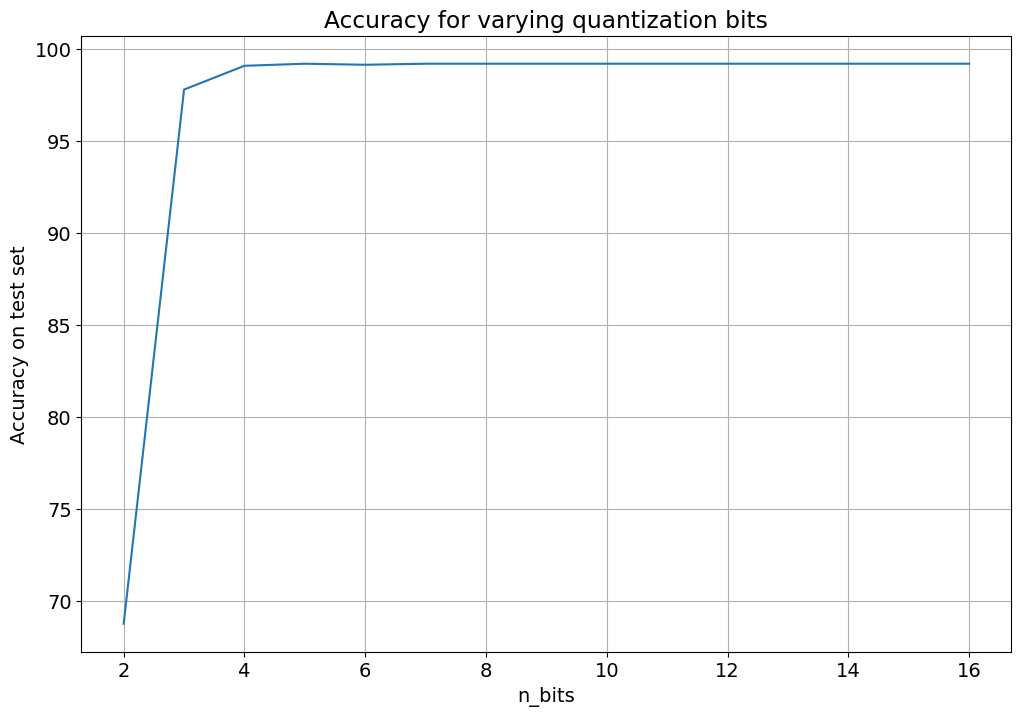

In [24]:
n_bits_max = 16

test_bits = []
test_accs = []

X_train, X_test, y_train, y_test = split(x,y)

for n_bits in range(2, n_bits_max+1):
    model = LogisticRegression(n_bits=n_bits)
    model.fit(X_train, y_train)
    model.compile(x)
    y_pred_fhe = model.predict(X_test, fhe='execute')

    # Results for n_bits = n_bits

    #print("Results for n_bits=",n_bits)
    # Accuracy
    model_accuracy = accuracy_score(y_test, y_pred_fhe) * 100
    print(f"{model_accuracy:.4f}%")

    test_bits.append(n_bits)
    test_accs.append(model_accuracy)
    #print("")
    # Balanced Accuracy
#     model_bal = balanced_accuracy_score(y_test, y_pred_fhe) * 100
#     print(f"Balanced accuracy: {model_bal:.4f}")
#     # F1 Score
#     model_f1 = f1_score(y_test, y_pred_fhe, average='weighted') * 100
#     print(f"F1 Score: {model_f1:.4f}")

fig = plt.figure(figsize=(12, 8))
plt.rcParams["font.size"] = 14

x = test_bits
y = test_accs

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('n_bits')
# naming the y axis
plt.ylabel('Accuracy on test set')

# giving a title to my graph
plt.title('Accuracy for varying quantization bits')

plt.grid(True)

# function to show the plot
plt.show()